# Filtro de señales y extracción de datos
De manera frecuente nos encontramos con que no tenemos acceso a los datos, es por esto que el siguiente ejercicio pretende mostrar una forma de extraer datos de ciertas bases de datos. para esto, revise la [pagina](http://lobo.satlantic.com/), la idea es extraer los datos de las temperaturas, del oceano en "Northwest Arm, Halifax, Canada". Primero existen dos formas utiles de acceder a los datos.

In [1]:
import urllib
from io import StringIO
from io import BytesIO
import csv
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
import pandas as pd
import scipy.signal as signal

## Forma facil
Para esto es util hacer uso de la libreria ``Pandas``. para esto primero consultamos como se pueden consultar los datos, en el siguiente [link](http://lobo.satlantic.com/cgidoc/) se observa una descripción pequeña de como acceder a esto

In [2]:
Inicio = '20111118'
Final   = '20121125'
datos=pd.read_csv('http://lobo.satlantic.com/cgi-data/nph-data.cgi?min_date='+Inicio+'&max_date='+Final+'&y=temperature',sep="\t")
datos["date [AST]"]=pd.to_datetime(datos["date [AST]"],format='%Y%m%d %H:%M:%S')
datos.set_index(["date [AST]"],inplace=True)

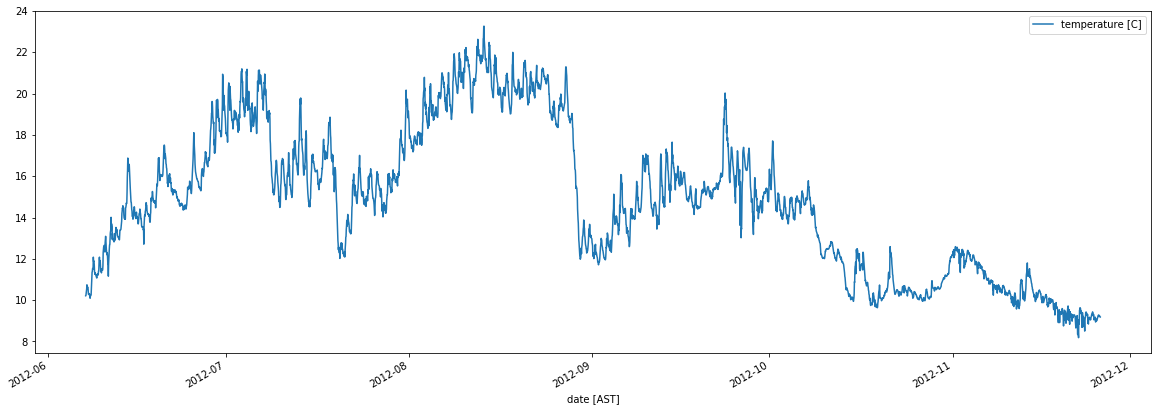

In [3]:
datos.plot(figsize=(20,7))
plt.show()

## Forma dificil
De ves en cuando los datos no están como los quisieramos por cuestiones de seguridad aveces se encriptan o tal vez están en cierto formato que pesa menos(binario por ejemplo).

In [4]:
Inicio = '20111118'
Final   = '20121125'
response=urllib.request.urlopen('http://lobo.satlantic.com/cgi-data/nph-data.cgi?min_date='+Inicio+'&max_date='+Final+'&y=temperature')
leer=response.read()
data = StringIO(leer.decode())
r = csv.DictReader(data,dialect=csv.Sniffer().sniff(data.read(1000)))
data.seek(0)
date, temp = [],[]
date, temp = zip(*[(datetime.strptime(x['date [AST]'], "%Y-%m-%d %H:%M:%S"), x['temperature [C]']) for x in r if x['temperature [C]'] is not None])
temp = np.array(temp)
temp = temp.astype(np.float)

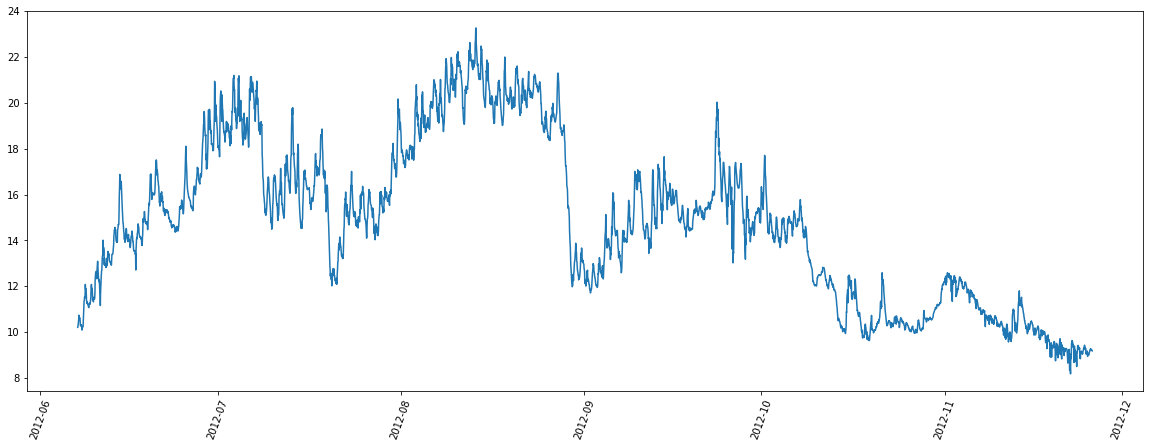

In [5]:
plt.figure(figsize=(20,7))
plt.plot(date,temp)
plt.xticks(rotation=70)
plt.show()

## Filtro
Primero se escogen los parametros que se desean para hacer el filtro entre estos está el orden del filtro y la frecuencia para hacer el filtro, de igual forma se puede efectuar un filtro de tipo pasabajos o pasa altos entre otros.
El filtro a utilizar acá será el de Butterworth, así de esta forma tenemos que:

In [6]:
N  = 2    # Orden del filtro
Wn = 0.01 # Corte de frecuancia
B, A = signal.butter(N, Wn)

In [8]:
temp_filtrada = signal.filtfilt(B,A, temp)

Así de esta forma podemos filtrar el valor de temperaturas y luego graficar la señal original y la señal filtrada, al igual que el ruido como la diferencia entre la señal original y el ruido.

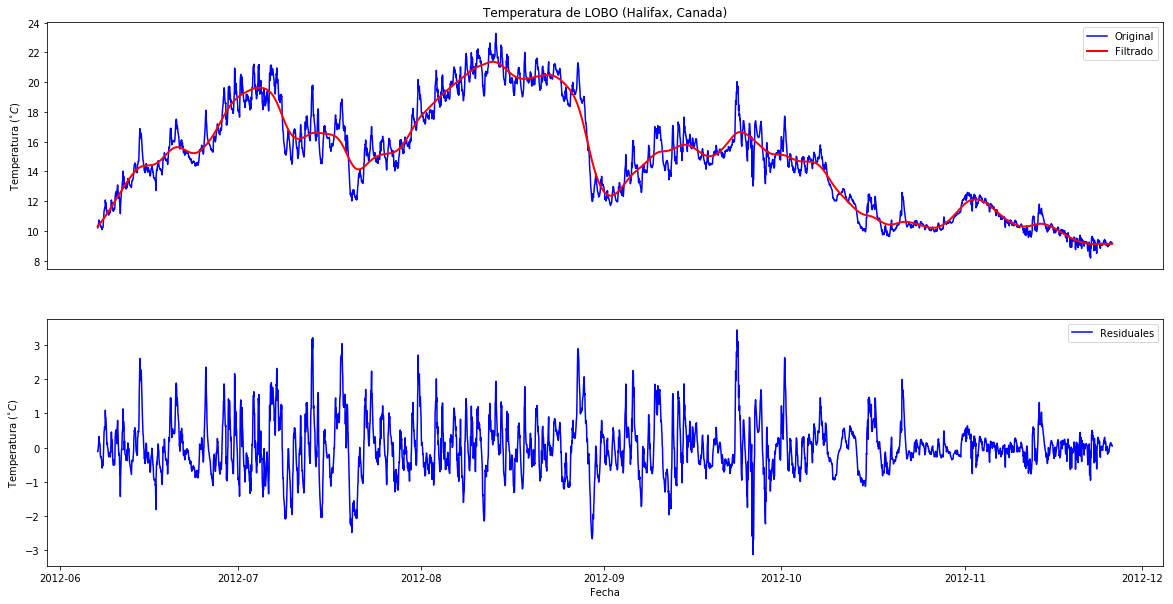

In [9]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
plt.plot(date,temp, 'b-')
plt.plot(date,temp_filtrada, 'r-',linewidth=2)
plt.ylabel(r"Temperatura ($^{\circ}C$)")
plt.legend(['Original','Filtrado'])
plt.title("Temperatura de LOBO (Halifax, Canada)")
ax1.axes.get_xaxis().set_visible(False)
ax1 = fig.add_subplot(212)
plt.plot(date,temp-temp_filtrada, 'b-')
plt.ylabel(r"Temperatura ($^{\circ}C$)")
plt.xlabel("Fecha")
plt.legend(['Residuales'])
plt.show()

Así mismo es posible calcular la autocorrelación entre dos señales, para esto resulta util hacer uso del modulo correlate de ``scipy.signal``.

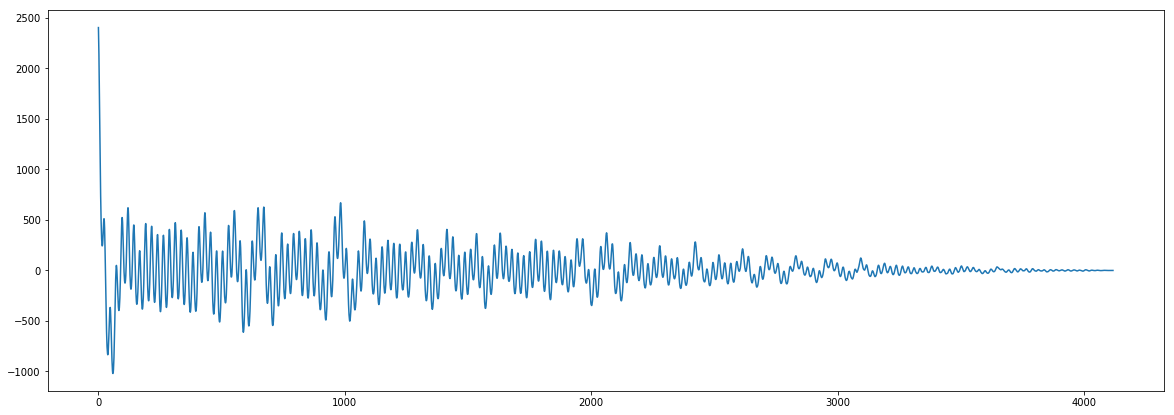

In [11]:
plt.figure(figsize=(20,7))
ruido=temp-temp_filtrada
corr=signal.correlate(ruido,ruido,mode="full")
plt.plot(corr[len(corr)//2:])
plt.show()

O si se desea hacer uso de la librería de ``numpy``, se obtiene el mismo resultado.

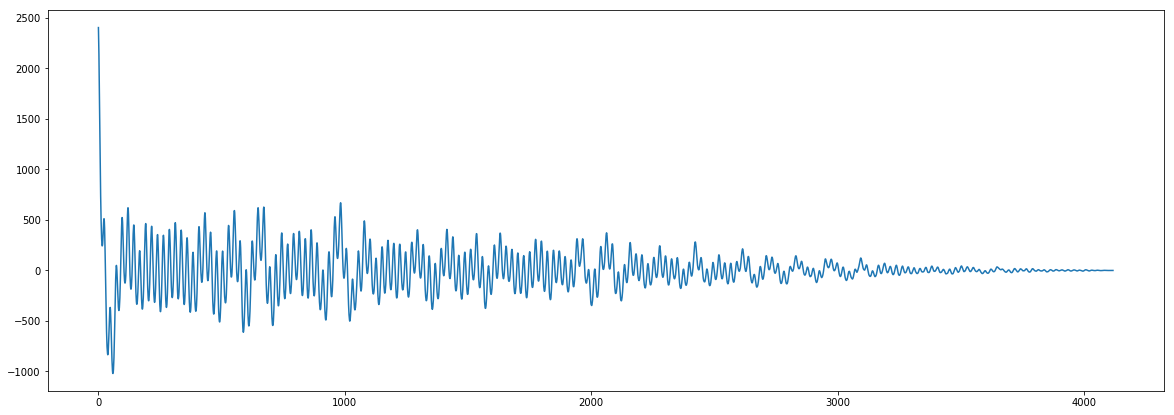

In [12]:
plt.figure(figsize=(20,7))
corr=np.correlate(ruido,ruido,mode="full")
plt.plot(corr[len(corr)//2:])
plt.show()

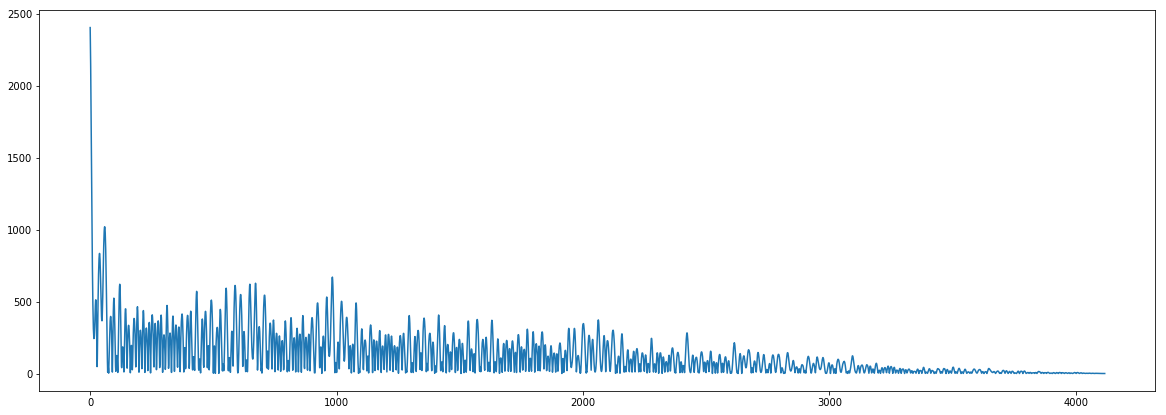

In [13]:
plt.figure(figsize=(20,7))
corr=np.correlate(ruido,ruido,mode="full")
plt.plot(np.abs(corr[len(corr)//2:]))
plt.show()